# Subject data to catatonia prediction 
Data includes: 
    - Bush-Francis pre/post treatment
    - Drugs and doses pre/post treatment for antipsychotic, lamotragine and benzos
* Drug doses are used to calculate target concentration and target occupation.
* Target occupations are coupled to Wilson-Cowan model parameters. 
* Model parameters are optimized for catatonia symptoms.

In [1]:
%matplotlib inline
from IPython.display import display   # To print DataFrames nicely
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
root_path = '/home/ec2-user/SageMaker/cascadia-behavioral-healthcare'
sys.path.insert(1, root_path + '/src')
data_path = root_path + '/data' # location of data files

### Transform target occupations to Wilson_Cowan model parameters
Wilson-Cowan description of cortical states generated by excitatory-inhibitory neural pools.
Population of excitatory and inhibitory neurons:
$$\tau_0 \dot{u_0} = -u_0 + f(w_{00}u_0 + w_{01}u_1 + I_0)$$
$$\tau_1 \dot{u_1} = -u_1 + f(w_{10}u_0 + w_{11}u_1 + I_1)$$
where for the E-I circuit, $w_{00}<0$ and $w_{01}<0$.

### Define class to convert clinical dose data to Wilson-Cowan model parameters

In [2]:
clinical_data = pd.read_csv('synth_drug_BF__07212022.csv')
clinical_data.head()

,Unnamed: 0,patient,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
0,0,a,18,6,NaN,NaN,NaN,20.0,3.0,NaN,...,NaN,4.00,800.0,NaN,NaN,500.0,NaN,2.0,NaN,NaN
1,2,c,14,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.00,550.0,NaN,NaN,450.0,NaN,NaN,NaN,NaN
2,7,h,16,5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.50,550.0,NaN,NaN,500.0,NaN,NaN,NaN,NaN
3,8,i,22,4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.00,250.0,NaN,NaN,400.0,NaN,NaN,NaN,NaN
4,9,j,14,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.75,NaN,NaN,NaN,450.0,NaN,2.0,45.0,NaN


In [3]:
clinical_mean = clinical_data.describe().loc[['min','mean','max']]
clinical_mean

,Unnamed: 0,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,pre_Fluphenazine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
min,0.000000,11.000000,0.000000,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,1.000000,1.000000,200.000000,250.0,NaN,400.000000,2.000000,2.0,20.0,NaN
mean,53.172414,17.275862,4.086207,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,1.166667,2.427632,456.578947,250.0,NaN,455.172414,2.333333,2.0,37.5,NaN
max,98.000000,26.000000,13.000000,2.0,600.0,NaN,20.0,3.0,NaN,10.0,...,2.000000,6.750000,1050.000000,250.0,NaN,500.000000,3.000000,2.0,45.0,NaN


In [4]:
test_drugs = ['post_Clozapine', 'post_Olanzapine', 'post_Lamotrigine', 'post_Clonazepam', 'post_Lorazepam']
# test_drugs = ['post_Clozapine', 'post_Olanzapine']
num_doses = 5
pharma_doses = clinical_data.loc[:1].reindex(list(range(0, len(test_drugs)*num_doses))).reset_index(drop=True)
pharma_doses.loc[:] = np.nan
pharma_doses.head()

,Unnamed: 0,patient,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
import string

for n, d in enumerate(test_drugs):
    dose_range = [0]*len(pharma_doses)
    dose_range[n*num_doses:n*num_doses+num_doses] = np.arange(0, clinical_mean.loc['max', d], 
                                                              clinical_mean.loc['max',d]/num_doses)
    pharma_doses[d] = dose_range
pharma_doses['pre_Clonazepam'] = np.zeros(len(pharma_doses))
pharma_doses['patient'] = clinical_data.loc[:len(pharma_doses),'patient']
# pharma_doses

In [6]:
import neural_mech.conc_effect as ce     # Custom code for calculating PK effects
# d2m = ce.Dose_Conversion(clinical_data)

# Load clinical data and seperate into pre/post-treatment datasets
data_file_name = 'synth_drug_BF_20_clientDrugs_04132017_L4+.csv'
# pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pd.read_csv(data_path + '/' 
#                                                                      + data_file_name))
# pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pd.read_csv(data_file_name))
pre_clinical, post_clinical = ce.seperate_clinical_pre_post(pharma_doses)

# Instantiate data processing objects for pre & post data
d2a_pre = ce.Dose_Conversion(pre_clinical)
d2a_post = ce.Dose_Conversion(post_clinical)

# Load pharmacokinetic information on relevant drugs
drugParams = pd.read_excel(data_path + '/' + 'drugParams.xls', sheet_name='params')
d2a_pre.load_pharmacokinetic_info(drugParams)
d2a_post.load_pharmacokinetic_info(drugParams)

# Load drug affinity data and calculate target occupancy
pdspDataFile = 'kidb110121.txt'
kidb110121 = pd.read_csv(data_path + '/' + pdspDataFile, 
                                header=None, sep="\t", error_bad_lines=False, 
                                engine='python')
d2a_pre.load_drug_affinities(kidb110121)
d2a_post.load_drug_affinities(kidb110121)

In [7]:
# Calculate Wilson-Cowan parameter values corresponding to doses
model_param_pre = d2a_pre.dose_to_model(p_wt=0.35)
display(model_param_pre.head())

model_param_post = d2a_post.dose_to_model(p_wt=0.35)
display(model_param_post.head())

,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,mu0,mu1,th0,th1,w00,w01,w10,w11
0,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000
1,1.0,0.999578,1.000114,1.010442,1.0,1.000421,0.999886,1.000421
2,1.0,0.999171,1.000228,1.018548,1.0,1.000828,0.999772,1.000828
3,1.0,0.998778,1.000341,1.024808,1.0,1.001219,0.999659,1.001219
4,1.0,0.998398,1.000453,1.029705,1.0,1.001597,0.999547,1.001597


Clean dataframe for next step

In [8]:
model_param_post['BF_total'] =  post_clinical['post_total_bf'] 
model_param_post.loc['control','BF_total'] = 0

param_BF = model_param_post
print(param_BF.tail(1).index)
param_BF.drop(param_BF.tail(1).index, inplace=True)
param_BF.reset_index(drop=True, inplace=True)
print (len(param_BF))
param_BF.tail()

Index(['control'], dtype='object')
25


,mu0,mu1,th0,th1,w00,w01,w10,w11,BF_total
20,1.0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,NaN
21,1.0,1.0,1.000000,1.000000,1.014662,1.014662,1.000000,1.0,NaN
22,1.0,1.0,1.000000,1.000000,1.028144,1.028144,1.000000,1.0,NaN
23,1.0,1.0,1.000001,1.000001,1.040584,1.040585,0.999999,1.0,NaN
24,1.0,1.0,1.000001,1.000001,1.052099,1.052099,0.999999,1.0,NaN


### Load the neural model generator
Define a function to set the model parameters and compute the fixed points.

0 1.7696743875687586
1 1.5359464677037304
2 1.3638892979880128
3 1.238316935305452
4 1.143855840195445
5 1.7696743875687586
6 1.7579584457502466
7 1.7464384911188555
8 1.7372845634690752
9 1.7265574649798534
10 1.7696743875687586
11 1.7015491545234998
12 1.634229401474577
13 1.569821941638192
14 1.5047011805598018
15 1.7696743875687586
16 1.6622812198386807
17 1.5603188304184792
18 1.4676418422900037
19 1.3811498161646398
20 1.7696743875687586
21 1.5939203026958304
22 1.438473478805537
23 1.3018009362300722
24 1.1779635632645138


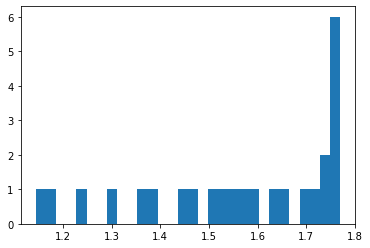

In [9]:
import neural_mech.neural_circuit as ncircuit
nc = ncircuit.Neural_Circuit()

model_pars = ['mu0','mu1','th0','th1','w00', 'w01','w10','w11']
barriers = []
# for index, row in param_BF.loc[:25].iterrows():
for index, row in param_BF.iterrows():
    pars = nc.default_pars()
    subject_pars = row
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
#     print(index, wc.find_fp(pars, 0, 0), wc.find_fp(pars, 0.4, 0.5), wc.find_fp(pars, 1, 0.9))
    barrier, i_nullcline = nc.calc_barrier(pars, verbose=False)
    barriers.append(barrier)
    print(index, barrier)

plt.hist(barriers, bins=30);

In [10]:
dose_range_idx = [i for i, e in enumerate(pharma_doses[d]) if e != 0]
pharma_doses.loc[dose_range_idx]
# barriers[dose_range_idx[0]:dose_range_idx[-1]]

,Unnamed: 0,patient,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
21,NaN,O,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,0.6,NaN,0.0,NaN
22,NaN,P,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,1.2,NaN,0.0,NaN
23,NaN,Q,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,1.8,NaN,0.0,NaN
24,NaN,R,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.0,0.0,NaN,NaN,0.0,2.4,NaN,0.0,NaN


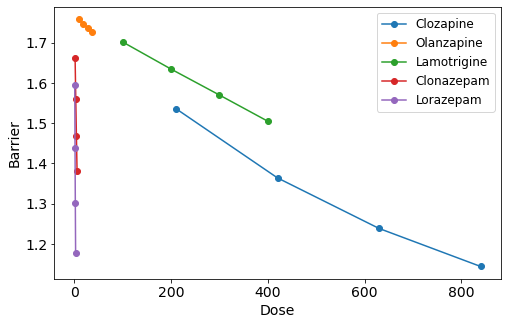

In [11]:
fig = plt.figure(figsize=(8,5))
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
for n, d in enumerate(test_drugs):
# for n, d in enumerate(['post_Clozapine','post_Olanzapine','post_Lamotrigine']):
#     plt.figure()
    dose_range_idx = [i for i, e in enumerate(pharma_doses[d]) if e != 0]
    plt.plot(pharma_doses.loc[dose_range_idx,d], 
             barriers[dose_range_idx[0]:dose_range_idx[-1]+1], 
             marker='o', label=d[5:])
    plt.ylabel('Barrier')
    plt.xlabel('Dose')
    plt.legend();
fig.savefig('./figs_publ/barrier_dose_response.tiff', dpi=300, format="tiff")

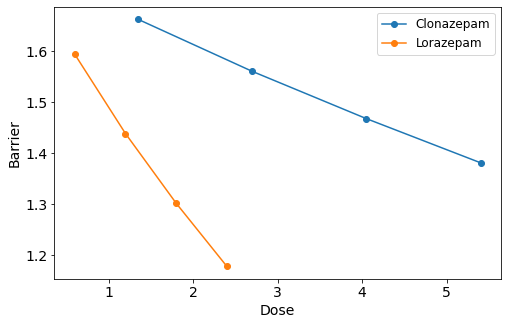

In [12]:
plt.figure(figsize=(8,5))
for n, d in enumerate(['post_Clonazepam','post_Lorazepam']):
#     plt.figure()
    dose_range_idx = [i for i, e in enumerate(pharma_doses[d]) if e != 0]
    plt.plot(pharma_doses.loc[dose_range_idx,d], 
             barriers[dose_range_idx[0]:dose_range_idx[-1]+1], 
             marker='o', label=d[5:])
    plt.ylabel('Barrier')
    plt.xlabel('Dose')
    plt.legend();

In [13]:
pharma_doses

,Unnamed: 0,patient,TotalPre,TotalPost,pre_Benztropine,pre_Carbamazepine,pre_Chlorpromazine,pre_Citalopram,pre_Clonazepam,pre_Clozapine,...,post_Benztropine,post_Clonazepam,post_Clozapine,post_Valproic_acid,post_Fluvoxamine,post_Lamotrigine,post_Lorazepam,post_Melatonin,post_Olanzapine,post_Sertraline
0,NaN,a,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN
1,NaN,c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,210.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN
2,NaN,h,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,420.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN
3,NaN,i,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,630.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN
4,NaN,j,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,840.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN
5,NaN,l,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,0.0,NaN,NaN,0.0,0.0,NaN,0.0,NaN
6,NaN,p,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,0.0,NaN,NaN,0.0,0.0,NaN,9.0,NaN
7,NaN,r,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,0.0,NaN,NaN,0.0,0.0,NaN,18.0,NaN
8,NaN,u,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,0.0,NaN,NaN,0.0,0.0,NaN,27.0,NaN
9,NaN,v,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,0.00,0.0,NaN,NaN,0.0,0.0,NaN,36.0,NaN


In [14]:
import json

# with open(data_path + '/' + 'init_drug_doses.json', 'r') as f:
with open(data_path + '/' + 'init_drug_doses_0721202.json', 'r') as f:
    drug_doses = json.load(f)
for d in drug_doses.keys():
    print(d, drug_doses[d])

pre_Benztropine [2.0]
pre_Carbamazepine [600.0]
pre_Chlorpromazine [100.0]
pre_Citalopram [20.0]
pre_Clonazepam [3.0, 5.0]
pre_Clozapine [150.0, 400.0, 1000.0]
pre_Fluphenazine [10.0]
pre_Fluvoxamine [25.0]
pre_Ziprasidone [160.0]
pre_Haloperidol [20.0, 30.0, 60.0]
pre_Lamotrigine [50.0, 250.0]
pre_Lorazepam [1.0, 2.0]
pre_Loxapine [50.0, 150.0]
pre_Olanzapine [20.0, 45.0]
pre_Oxcarbazepine [1500.0, 1800.0]
pre_Risperidone [50.0]
pre_Sertraline [100.0, 200.0]
pre_Zolpidem [10.0]
pre_Quetiapine [800.0]
pre_Valproic_acid [750.0, 1000.0, 1250.0, 2000.0]
post_Benztropine [1.0, 2.0]
post_Clonazepam [1.0, 1.5, 1.75, 3.0, 3.5, 4.0, 6.75, 9.0]
post_Clozapine [200.0, 250.0, 350.0, 550.0, 650.0, 800.0, 1050.0]
post_Valproic_acid [250.0]
post_Fluvoxamine [25.0]
post_Lamotrigine [400.0, 450.0, 500.0]
post_Lorazepam [1.5, 2.0, 3.0]
post_Melatonin [2.0]
post_Olanzapine [20.0, 45.0, 50.0]
post_Sertraline [200.0]


In [15]:
d2a_post.ki_receptor_drug[['Clozapine','Olanzapine']]

,Clozapine,Olanzapine
receptors,,
D1,89.0,25.00
D2,28.0,3.00
5-HT1A,104.8,610.00
5-HT2A,1.0,1.48
M1,1.4,2.00


In [16]:
d2a_post.pharma_pk[['param','Clozapine','Olanzapine']]

,param,Clozapine,Olanzapine
0,bioavailability,0.65,0.87
1,clearance (L/hr),31.00,21.80
2,blood/brain ratio,1.00,1.00
3,mole wt (g/mol),326.82,312.43
4,pk_param,1.00,1.00


In [17]:
dose_post_Lorazepam = list(pharma_doses['post_Lorazepam'].tail(5))
dose_post_Lorazepam

[0.0, 0.6, 1.2, 1.7999999999999998, 2.4]

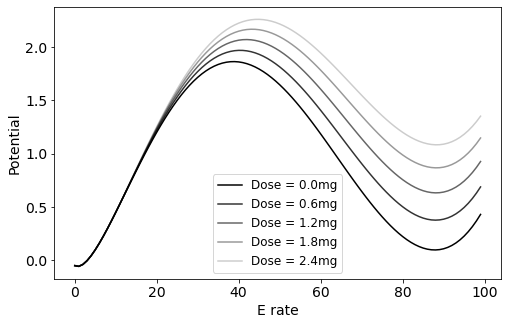

In [18]:
fig = plt.figure(figsize=(8,5))
for index, row in param_BF.tail(5).iterrows():
    pars = nc.default_pars()
    subject_pars = row
    for p in model_pars:
        pars[p] = pars[p]*subject_pars[p]
    nc.plot_potential(pars)
    
for ax in plt.gcf().axes:
    for n, al in enumerate(ax.get_lines()):
        al.set_color("black")
        al.set_alpha(1-n*0.2)
        al.set_label('Dose = '+str(round(dose_post_Lorazepam[n], 1))+'mg')
plt.legend()
plt.xlabel('E rate')
plt.ylabel('Potential');
# fig.savefig('./figs_publ/potential_dose_lor.tiff', dpi=300, format="tiff")

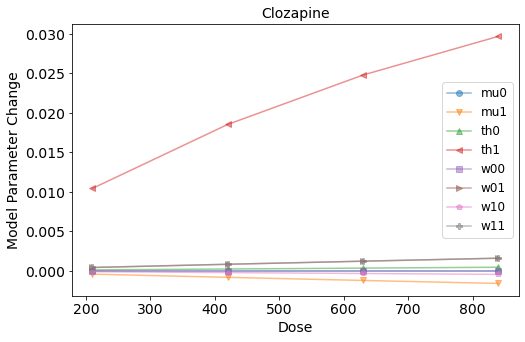

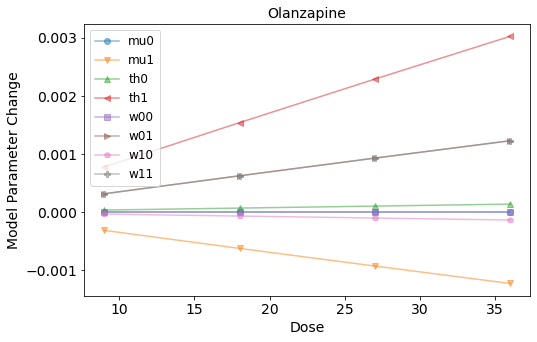

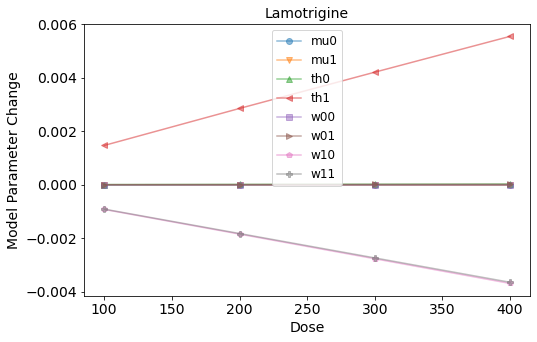

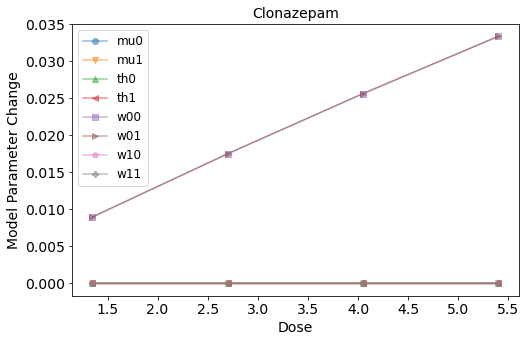

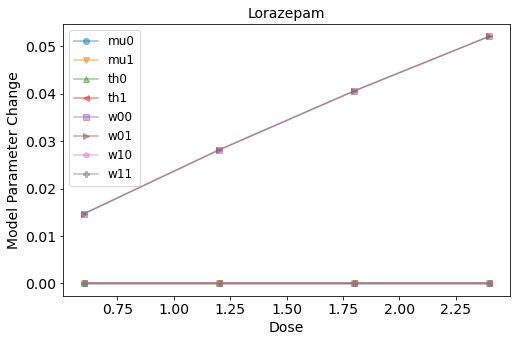

In [19]:
plt.rc('axes', titlesize=14)    # fontsize of the x and y labels
param_BF = param_BF.copy() - 1
# for n, d in enumerate(['post_Clozapine','post_Olanzapine','post_Lamotrigine']):
markers = ['o','v','^','<','s','>','p','P','*','h','H']
for n, d in enumerate(test_drugs):
    fig = plt.figure(figsize=(8,5))
    dose_range_idx = [i for i, e in enumerate(pharma_doses[d]) if e != 0]
    for m, p in enumerate(model_pars):
        plt.plot(pharma_doses.loc[dose_range_idx,d], 
                 param_BF[p][dose_range_idx[0]:dose_range_idx[-1]+1], 
                 marker=markers[m], label=p, alpha=0.5)
    plt.ylabel('Model Parameter Change')
    plt.xlabel('Dose')
    plt.title(d[5:])
    plt.legend();
#     if d[5:] in ['Clozapine', 'Lamotrigine', 'Clonazepam']:
#         fig.savefig('./figs_publ/param_change_'+d[5:].lower()+'.tiff', dpi=300, format="tiff")